In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image = cv2.imread('assets/detection_crop.png')

### Detect blob

In [3]:
from decoding_utils import get_blobs_keypoints_from_crop

In [4]:
keypoints, resize = get_blobs_keypoints_from_crop(image)

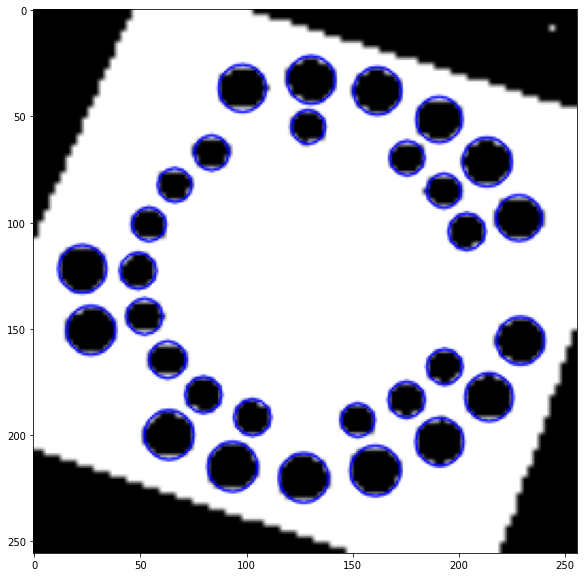

In [5]:
# Draw blobs on our image as blue circles
blank = np.zeros((1, 1))
blobs = cv2.drawKeypoints(resize, keypoints, blank, (0, 0, 255),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
plt.figure(figsize=(14, 10))
plt.imshow(blobs)

### Detecting the outermost circle

In [6]:
from decoding_utils import fit_ellipse_from_keypoints, get_keypoints_on_ellipse

/home/vince/Documents/personal_projects/medium_posts/fiducial_marker/python/decoding_utils.py:97: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2, label='Ellipse fit')


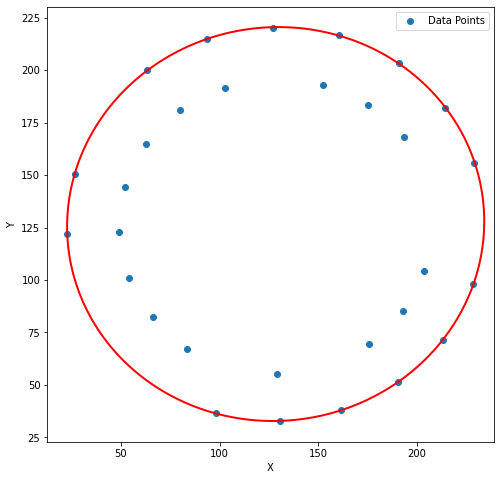

In [7]:
x, center = fit_ellipse_from_keypoints(keypoints, display=True)

In [8]:
kpts_on_ellipse = get_keypoints_on_ellipse(keypoints, x)

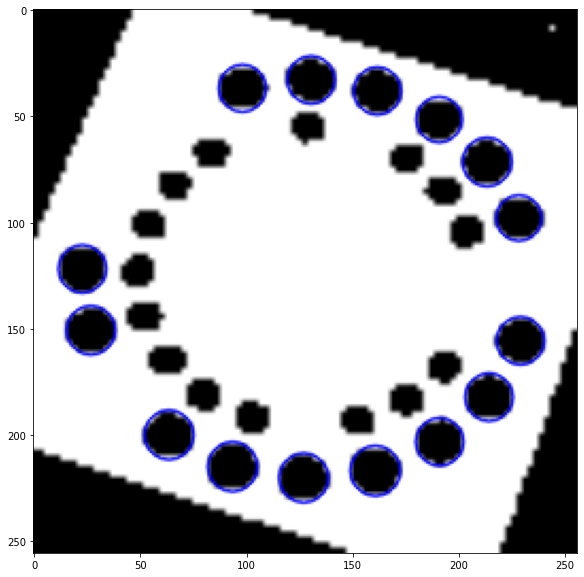

In [9]:
# Draw blobs on our image as blue circles
blank = np.zeros((1, 1))
blobs = cv2.drawKeypoints(resize, kpts_on_ellipse, blank, (0, 0, 255),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
plt.figure(figsize=(14, 10))
plt.imshow(blobs)

### Find matching points

In [10]:
from decoding_utils import find_longest_connected_points_on_ellipse, find_symmetric_point_in_connected

In [11]:
connected, _, min_dist = find_longest_connected_points_on_ellipse(kpts_on_ellipse, distance_threshold=1.8)

In [12]:
best_symmetry_idx = find_symmetric_point_in_connected(connected, kpts_on_ellipse, center, min_dist)

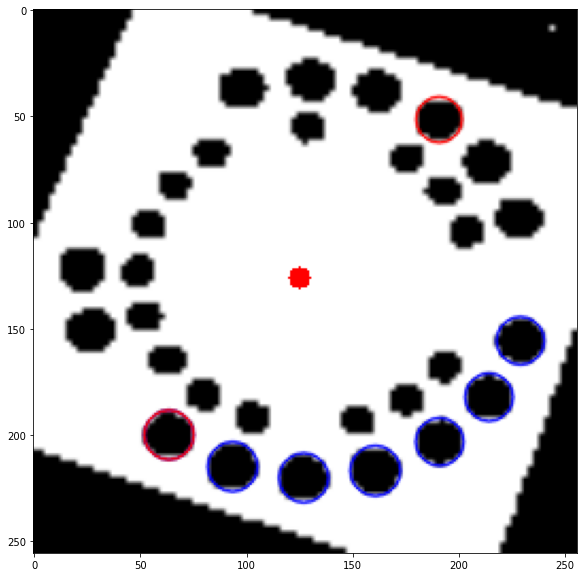

In [13]:
# Draw selected dots
blank = np.zeros((1, 1))
# Draw longest chain in blue
draw_kpts = [kpts_on_ellipse[i] for i in connected]
blobs = cv2.drawKeypoints(resize, draw_kpts, blank, (0, 0, 255),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# Draw symmetrical ones in red
draw_kpts = [kpts_on_ellipse[i] for i in best_symmetry_idx]
blobs = cv2.drawKeypoints(blobs, draw_kpts, blank, (255, 0, 0),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

blobs = cv2.circle(blobs, center.astype(int), 5, (255, 0, 0), thickness=-1)

# Show blobs
plt.figure(figsize=(14, 10))
plt.imshow(blobs)

### Unwarp image

In [14]:
from decoding_utils import generate_ref_points, get_keypoints_positions_from_indices

In [15]:
corrected_images = []
unwarping_offset = 2
for offset_index in range(-unwarping_offset, unwarping_offset + 1):
    # Get reference points
    ref_points = generate_ref_points(connected, best_symmetry_idx, num_layers=2, num_dots_per_layer=20, symmetry_index_offset=offset_index)
    # Get destination points
    dst_points = get_keypoints_positions_from_indices(kpts_on_ellipse, connected, best_symmetry_idx)
    # Compute homography
    H, _ = cv2.findHomography(dst_points, ref_points, 0, 5.0)
    # Correct image
    if H is not None:
        corrected_image = cv2.warpPerspective(resize, H, (307, 307))
        corrected_images.append(corrected_image)


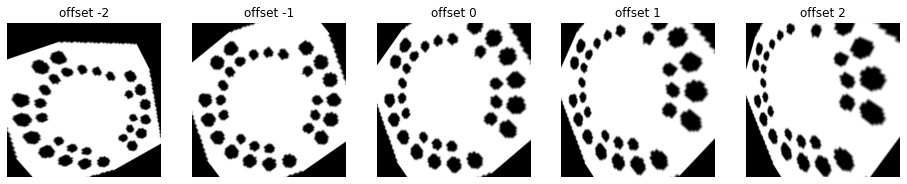

In [16]:
plt.figure(figsize=(16, 12))
for i in range(len(corrected_images)):
    plt.subplot(1, 5, i+1)
    plt.imshow(corrected_images[i], cmap='gray')
    plt.title(f'offset {-2 + i}')
    plt.axis('off')

### Marker decoding

In [17]:
from decoding_utils import decode_tag_from_image

In [18]:
code = decode_tag_from_image(corrected_images[1], num_layers=2, num_dots_per_layer=20)
code

377667386